In [5]:
from pathlib import Path
import tifffile as tiff
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
df = pd.read_csv("new/metadata.csv")
df["category"].value_counts()

category
Cargo                         9535
Tanker                        2733
Other Type                    1958
Fishing                        204
Tug                            150
Dredging or underwater ops     147
Passenger                       95
Dredging                        40
Law Enforcement                 37
Pilot Vessel                    28
Towing                          18
High speed craft                13
Port Tender                     12
Search                          12
Wing in ground                  11
Search and Rescue vessel         7
Pleasure Craft                   5
Reserved                         2
Anti-pollution equipment         1
Diving ops                       1
Name: count, dtype: int64

In [8]:
for file_path in Path("new/PATCH_CAL").iterdir():
    img = tiff.imread(file_path).astype(np.float32)
    img_resized = resize(img, (64, 64), order=3, mode='reflect', preserve_range=True)
    if (img_resized.shape != (64, 64, 2)):
        print(img.shape)
        print(f"Error resizing {file_path.name}: got shape {img_resized.shape}")
    tiff.imwrite("resized_new/" + file_path.name, img_resized.astype(np.float32))

In [16]:
for file_path in Path("resized").iterdir():
    img = tiff.imread(file_path).astype(np.float32)
    print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')
    img_std = (img - global_mean) / global_std
    print(f'dtype: {img_std.dtype}, shape: {img_std.shape}, min: {np.min(img_std)}, max: {np.max(img_std)}')
    tiff.imwrite("standardised/" + file_path.name, img_std.astype(np.float32))

dtype: float32, shape: (64, 64, 2), min: 0.0, max: 26.555240631103516
dtype: float32, shape: (64, 64, 2), min: -0.016202131286263466, max: 3.9910242557525635
dtype: float32, shape: (64, 64, 2), min: 0.0005284923827275634, max: 9.685580253601074
dtype: float32, shape: (64, 64, 2), min: -0.016122380271553993, max: 1.4453667402267456
dtype: float32, shape: (64, 64, 2), min: 0.0002698426542337984, max: 18.757923126220703
dtype: float32, shape: (64, 64, 2), min: -0.01616141013801098, max: 2.814397096633911
dtype: float32, shape: (64, 64, 2), min: 0.0007800116436555982, max: 24.446271896362305
dtype: float32, shape: (64, 64, 2), min: -0.016084427013993263, max: 3.6727776527404785
dtype: float32, shape: (64, 64, 2), min: 0.00026508490554988384, max: 219.12054443359375
dtype: float32, shape: (64, 64, 2), min: -0.016162129119038582, max: 33.04942321777344
dtype: float32, shape: (64, 64, 2), min: 0.00020083633717149496, max: 60.07466506958008
dtype: float32, shape: (64, 64, 2), min: -0.016171824

In [95]:
from scipy.ndimage import label as scipy_label
from skimage import measure

def extract_scale_variant_features(stacked_image, standardised_img, incidence_angle):
    """
    Extract 14 scale-variant features as described in Table 2
    Uses original size images before resizing
    """
    features = np.zeros(14, dtype=np.float32)
    
    # 1. Angle of incidence
    features[0] = incidence_angle
    
    # Ship detection using CA-CFAR (Eq. 2, 3)
    vh_img = stacked_image[:,:,0]
    binary_mask = ca_cfar_detection(vh_img)
    
    # Get region properties
    labeled_img, num_features_detected = scipy_label(binary_mask)

    if num_features_detected > 0:
        props = measure.regionprops(labeled_img, intensity_image=stacked_image) 
        
        # Take largest region as ship
        ship = max(props, key=lambda x: x.area)
        
        # 2. Length (from minimum bounding rectangle)
        y0, x0, y1, x1 = ship.bbox
        features[1] = max(y1 - y0, x1 - x0)
        
        # 3. Total pixels
        features[2] = ship.area
        
        # 4. Mass (sum of intensity values)
        features[3] = vh_img[labeled_img == ship.label].sum()
        
        # 5. Area of minimum bounding rectangle
        features[4] = ship.bbox_area
        
        # 6-7. Significance (Eq. 4)
        ship_pixels = vh_img[labeled_img == ship.label].astype(np.float32)
        background_pixels = vh_img[labeled_img != ship.label].astype(np.float32)

        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        plt.figure(figsize=(6,6))
        plt.imshow(standardised_img[:, :, 0], cmap='gray')

        # Draw axis-aligned bounding box
        rect = patches.Rectangle(
            (x0, y0),                  # (x, y)
            x1 - x0,                   # width
            y1 - y0,                   # height
            linewidth=2, edgecolor='red', facecolor='none'
        )
        plt.gca().add_patch(rect)

        plt.title("Ship with Axis-Aligned Bounding Box")
        plt.axis('off')
        plt.show()

        m_t = ship_pixels.mean()
        m_max = ship_pixels.max()
        m_b = background_pixels.mean()
        s_b = background_pixels.std()

        if len(background_pixels) > 0:
            bg_mean = background_pixels.mean()
            bg_std = background_pixels.std()
            
            if bg_std > 0:
                features[5] = (m_t - bg_mean) / bg_std  # significance_mean
                features[6] = (m_max - bg_mean) / bg_std   # significance_max
        
        # 8-14. Hu moments (7 invariant moments)
        hu_moments = ship.moments_hu
        features[7:14] = hu_moments
    
    # Normalize features to [0, 1] range (Eq. 5)
    # Note: This should ideally be done across entire dataset
    # For now, we'll do a simple normalization
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return features

def ca_cfar_detection(image, pfa=1e-3):
    """
    CA-CFAR ship detection as per Eq. (2) and (3)
    """
    N = image.size
    alpha = N * (pfa ** (-1/N) - 1)
    
    background_mean = image.mean()
    threshold = alpha * background_mean
    
    binary_mask = image > threshold
    return binary_mask

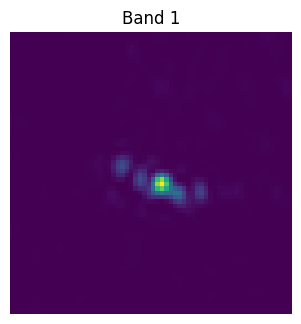

In [9]:
img = tiff.imread("resized_new/Tanker_x27299_y4677.tif").astype(np.float32)
# img2 = tiff.imread("standardised/Fishing_x56716_y4043.tif").astype(np.float32)

plt.figure(figsize=(8,4))

# Band 1
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Band 1")
plt.axis('off')

# Band 2
# plt.subplot(1,2,2)
# plt.imshow(img2[:, :, 0])
# plt.title("Band 2")
# plt.axis('off')

plt.show()

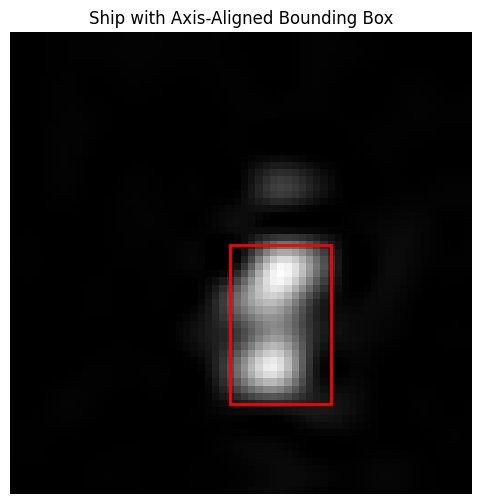

Extracted Features: [ 4.4054241e+01  2.2000000e+01  2.0100000e+02  3.7632500e+01
  3.0800000e+02  1.3685548e+01  2.3573027e+01  2.2518334e-01
  2.1293784e-02  2.8859882e-04  2.5540947e-05 -1.1331573e-09
 -2.3745745e-06 -1.8773409e-09]


In [106]:
features = extract_scale_variant_features(img, img2, incidence_angle=44.05424)
print("Extracted Features:", features)

In [84]:
import pandas as pd

df = pd.read_csv("dataset/metadata.csv")
df.loc[df["patch_cal"] == "Fishing_x56716_y4043.tif"]["Incidence"]

5308    44.05424
Name: Incidence, dtype: float64